# chapter05. RNN (Recurrent Neural Network)
former model was 'feedforward' model. it sends information in one direction.  
its easy to understand, but it has hard time learning pattern in time.  
we deconstruct feedforward model, and we suggest and implement RNN model.

## 5.1 probability and language model
### 5.1.1 word2vec in peobability perspective.
P(w| w+, w-) is our model.  
but lets consider P(w| w-1, w-2)  
then L = -log(P(w| w-1, w-2 ))

### 5.1.2 language model
language model gives probability to sequence of words.  
 > P(A,B) = P(A|B) * P(B)  
P(w1, w2, ... wm) = PI{P(wt| w1, ... wt-1)}  
  
language model considers many words before wt

### 5.1.3 CBOW model into Language model
we can make such model, but it has one problem: our size of window is restricted.  
even if we managed to expand our window, the sequence is neglected.  
solution requires completely new model: RNN  
RNN preserves context no matter how long is the context.  

## 5.2 RNN(Recurrent Neural Network)
### 5.2.1 Recurrent 
in order to have Recurrence, we need "closed path". so we can repeat them.  
### 5.2.2 Expanding Recurring structure
we can expand RNN horizontally.  
multiple RNN is identical.  
basic formular of RNN : h_t = tanh(h_t-1 * W_h + x * W_x + b)  
  
RNN has two weight.  
1. W_x: weight to convert x into h
2. W_h: weight to make input for next RNN

### BPTT(BackPropagation Through Time)
BackPropagation part is similar with neural network.  
problem 1: as RNN gets longer, backpropagation gets heavier.  
problem 2: as RNN gets longer, gradient from backpropagation gets unstable.

### 5.2.4 Truncated BPTT
we save context in forward propagation.  
we cut our backpropagation, lets say in unit of 10 words.  

### 5.2.5 Truncated BPTT's minibatch training 
Truncated BPTT is simple, but be careful when you feed an input.  
if you have 1000 words, and you make batch size of 500, second batch will start from 500.  

## 5.3 Implementing RNN
we get input size of T.  
we can think this whole RNN into one layer. input as xs, and output as hs.  
we call this big layer "Time RNN"

### 5.3.1 RNN layer Implementing 
be careful for deminsion compatibility.  
minibatch size: N  
input vector size: D  
hidden vector size: H  

In [1]:
import numpy as np

In [2]:
# common/time_layers.py
class RNN: 
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx)+ b
        h_next = np.tanh(t)
    
        self.cache(x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next ** 2)
        db = np,sum(dt, axix = 0)
        dWh = np.matmul(h_prev.T, dt) # Q: what is T??
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev
    

### 5.3.2 Time RNN layer Implementation

In [4]:
#common/time_layers.py
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful = False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.dh = None, None # 은닉변수들
        self.stateful = stateful # True -> TimeRNN does not truncate. False -> it makes hidden variable into 0. 
        
    def set_stateful(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        
        for t in range (T):
            layer = RNN(*self.params)       # '*' in here extract elements from list and put them in parameter of method.  
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, D = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0,0,0]
        for t in reversed(range(T)): 
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:,t,:] + dh ) # summed grads
            dxs[:, t, :] = dx
            
            for i, grads in enumerate(layer.grads):
                grads[i] += grad
                
            for i, grad in enumerate(grads):
                self.grads[i][...] = grad
            self.dh = dh
            
            return dxs
            

## 5.4 time series data layer implementation
we will make RNNLM

### 5.4.1 RNNLM
we have 4 layers.
1. Embedding layer: converts wordid into vector. 
2. RNN
3. Affine
4. Softmax: finally outputs yt

### 5.4.2 Time layer
we will make TimeXX layer.  
XX layer that processes T amounts of Time series data.  
its in the common/time_layers.py

## 5.5 Training amd Evaluating RNNLM

### 5.5.1 implementing RNNLM
we will make simple class SimpleRnnlm

its in the ch05/simple_rnnlm.py

### 5.5.2 evaluating language model
perplexity(혼란도): inverse of probability.  
we want smaller perplexity.  
we can think perplexity as number of branches.  
if perp(x) = 1.25, there are 1.25 amount of possible words.  
if perp(x) = 10, there are around 10 possible branches of words.  
  
but what if we want to evaluate multiple inputs?  
L = -(1/N) * SUM{ SUM{ t_nk * log(y_nk) }}  
perplexity = exp(L)

### 5.5.3 RNNLM's training code
is in ch05/train_custom_loop.py

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 395.79
| 에폭 2 | 퍼플렉서티 268.60
| 에폭 3 | 퍼플렉서티 226.76
| 에폭 4 | 퍼플렉서티 215.26
| 에폭 5 | 퍼플렉서티 205.30
| 에폭 6 | 퍼플렉서티 202.72
| 에폭 7 | 퍼플렉서티 198.14
| 에폭 8 | 퍼플렉서티 196.79
| 에폭 9 | 퍼플렉서티 190.71
| 에폭 10 | 퍼플렉서티 193.16
| 에폭 11 | 퍼플렉서티 189.30
| 에폭 12 | 퍼플렉서티 192.58
| 에폭 13 | 퍼플렉서티 190.57
| 에폭 14 | 퍼플렉서티 190.17
| 에폭 15 | 퍼플렉서티 189.53
| 에폭 16 | 퍼플렉서티 186.46
| 에폭 17 | 퍼플렉서티 184.10
| 에폭 18 | 퍼플렉서티 180.66
| 에폭 19 | 퍼플렉서티 182.51
| 에폭 20 | 퍼플렉서티 183.51
| 에폭 21 | 퍼플렉서티 181.91
| 에폭 22 | 퍼플렉서티 178.26
| 에폭 23 | 퍼플렉서티 174.94
| 에폭 24 | 퍼플렉서티 174.91
| 에폭 25 | 퍼플렉서티 172.91
| 에폭 26 | 퍼플렉서티 174.41
| 에폭 27 | 퍼플렉서티 167.70
| 에폭 28 | 퍼플렉서티 165.92
| 에폭 29 | 퍼플렉서티 163.29
| 에폭 30 | 퍼플렉서티 158.20
| 에폭 31 | 퍼플렉서티 157.39
| 에폭 32 | 퍼플렉서티 154.17
| 에폭 33 | 퍼플렉서티 153.04
| 에폭 34 | 퍼플렉서티 147.14
| 에폭 35 | 퍼플렉서티 146.13
| 에폭 36 | 퍼플렉서티 137.93
| 에폭 37 | 퍼플렉서티 135.04
| 에폭 38 | 퍼플렉서티 131.60
| 에폭 39 | 퍼플렉서티 124.96
| 에폭 40 | 퍼플렉서티 120.69
| 에폭 41 | 퍼플렉서티 119.96
| 에폭 42 | 퍼플렉서티 112.98
| 에폭 43 | 퍼플렉서티 108

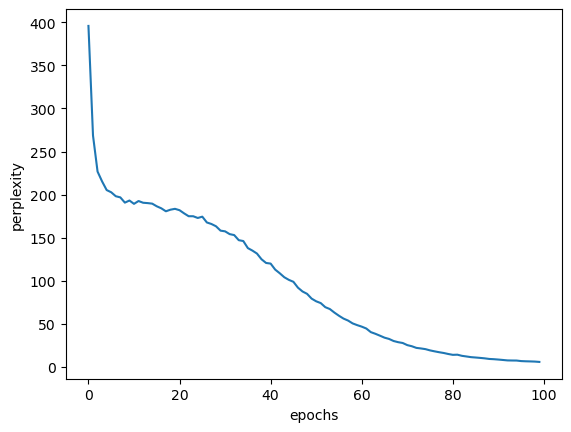

In [5]:
import train_custom_loop

In [9]:
import train_custom_loop